# BART Tutorial: Reconstruction of Dynamic Contrast Enhanced (DCE) MRI
## Practical Tools for Applying Compressed Sensing to 2D+Time Data

### Part 2
  
  
=========================================================================================================================

Hello, welcome back!

This is the **second** notebook of the Dynamic MRI tutorial. It is assumed that you are familiar with the materical in the first notebook, which is included in this repository and in named BART_DCE_demo.ipynb.

This notebook includes additional demonstrations of ``bart pics`` with these regularizers:
1. l1-wavelet in space
2. Total Variation (TV) in time
3. l1-wavelet in space + TVC in time

Notice: this notebook should be run using a Python3 kernel.

Efrat Shimron, UC Berkeley (efrat.s@berkeley.edu) and Jon Tamir, UT Austin (jtamir@utexas.edu).

December 2020


In [1]:
import sys
import os

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# After having updated your `PYTHONPATH`, the following commands should execute error-free:
from bart import bart
import cfl


**Optional** -  to display 2D+T figures using SigPy, install Sigpy (https://pypi.org/project/sigpy/) and import its tools as follows (notice that this is not necessary, you can also display images using other libraries, such as matplotlib).


In [3]:
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr

# for displaying figs with Sigpy:
%matplotlib notebook

In [4]:
# check your bart version by running this command - it is recommended to have the most updated version (v0.6.00)
! bart version

v0.6.00


## BART's interfaces

Generally, we have two options for working with BART when using a Jupyter notebook with a python kernel:

1. Using the **Command Line Interface (CLI)**
2. Using **BART's python binder** - this enables reading the data from cfl into numpy arrays and working with numpy. 


### Introduction to BART's python binding

The `bart` module allows a user to execute any BART command-line tool via the following format:

`<outputs> = bart(<nargs>, <command>, <arguments>, ...)`

Where:

`<outputs>`: the output of a BART command

`<nargs>`: the number of outputs

`<command>`: the command string and necessary flags

`<arguments>`: the `<nargs>` data files passed in for use in the function

# Reconstruction 

We will use the `pics` tool to perform ESPIRiT-based parallel imaging and compressed sensing. The basic usage is

    bart pics [optimization options] [regularization options] kspace maps recon
    
See the full list with `bart pics -h`.
There are several built-in regularization terms and transforms. We can see the options by invoking the help:

In [ ]:
! bart pics -h

### Regularization

There are various options for regularization with bart pics. 
To see the different options for pics regularization, use `bart pics -Rh` flag:


In [ ]:
! bart pics -Rh

In the next few sections we will show how to reconstruct the 2D+Time data using different regularizers. 

## Regularization Example 1: *l*1-wavelet Regularizer in the Spatial Domain

#### option 1: using the CLI

In [5]:
! bart pics -d 5  -i 30 -p data/weights -R W:$(bart bitmask 0 1 2):0:0.005 data/ksp data/maps data/recon_l1wav

2 maps.
ESPIRiT reconstruction.
Size: 220320 Samples: 17236 Acc: 12.78
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 1x5x2, pos: 0x31x89)
Scaling: 329041.093750! (max = 329041.093750/p90 = 329041.093750/median = 153375.046875)
Inverse scaling of the data: 329041.093750
l1-wavelet regularization: 0.005000
FISTA
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 2-3 of 5.
Linking args 2-3 of 5.
#It 000: 1.000000   
#It 001: 0.266172   
#It 002: 0.116492   
#It 003: 0.066711   
#It 004: 0.042221   
#It 005: 0.027541   
#It 006: 0.019003   
#It 007: 0.014500   
#It 008: 0.011795   
#It 009: 0.009718   
#It 010: 0.008024   
#It 011: 0.006743   
#It 012: 0.005852   
#It 013: 0.005262   
#It 014: 0.004839   
#It 015: 0.004612   
#It 016: 0.004402   
#It 017: 0.004241   
#It 018: 0.004193   
#It 019: 0.004065   
#It 020: 0.003956   
#It 021: 0.003881   
#It 022: 0.0

<IPython.core.display.Javascript object>


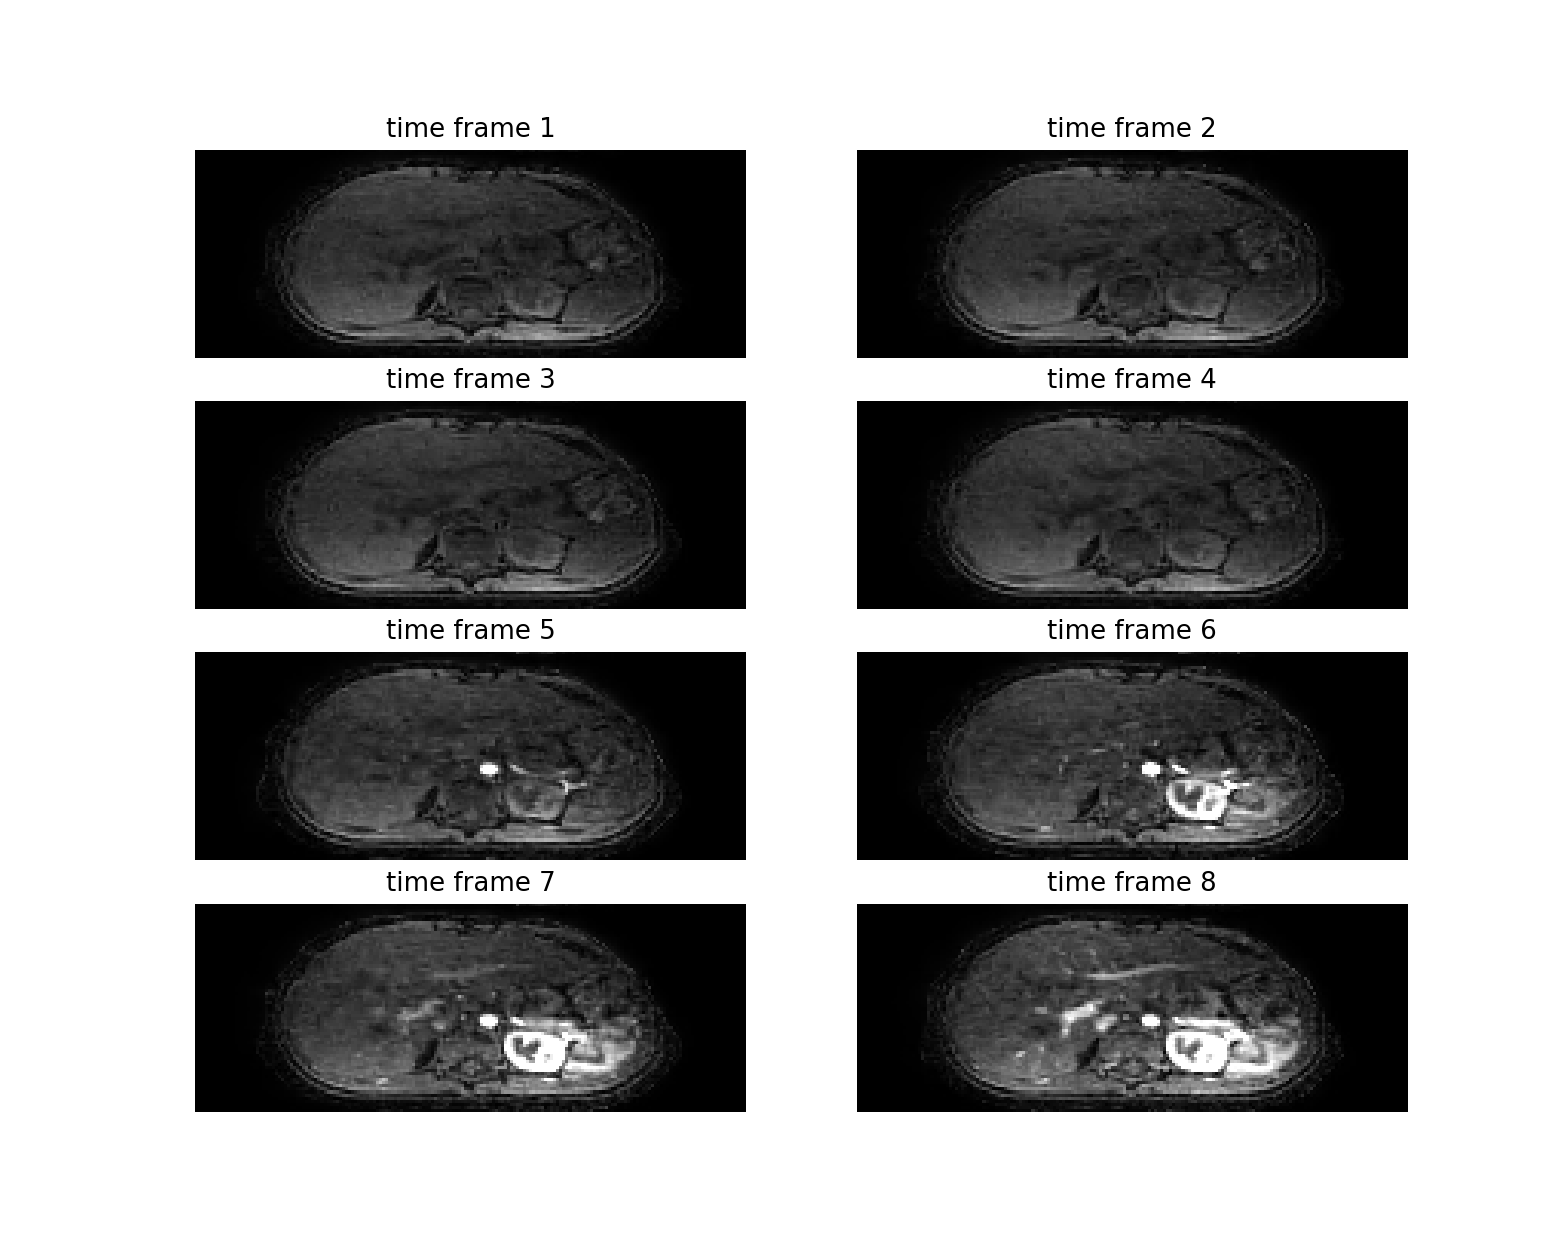

In [6]:
# load
recon_l1wav_CLI = cfl.readcfl('data/recon_l1wav')
recon_l1wav_CLI_sqz = recon_l1wav_CLI[0,:,:,0,0,0,0,0,0,0,:].squeeze()

# display - let's view the first 8 time frames (of 20)
fig = plt.figure(figsize = (10,8))
for t_ind in range(8):
    im_frame = recon_l1wav_CLI_sqz[:,:,t_ind].squeeze()
    plt.subplot(4,2,t_ind+1)
    plt.imshow(np.abs(im_frame),cmap="gray")
    plt.clim(0,5)
    plt.axis('off')
    plt.title('time frame {}'.format(t_ind+1))
plt.show()

<IPython.core.display.Javascript object>


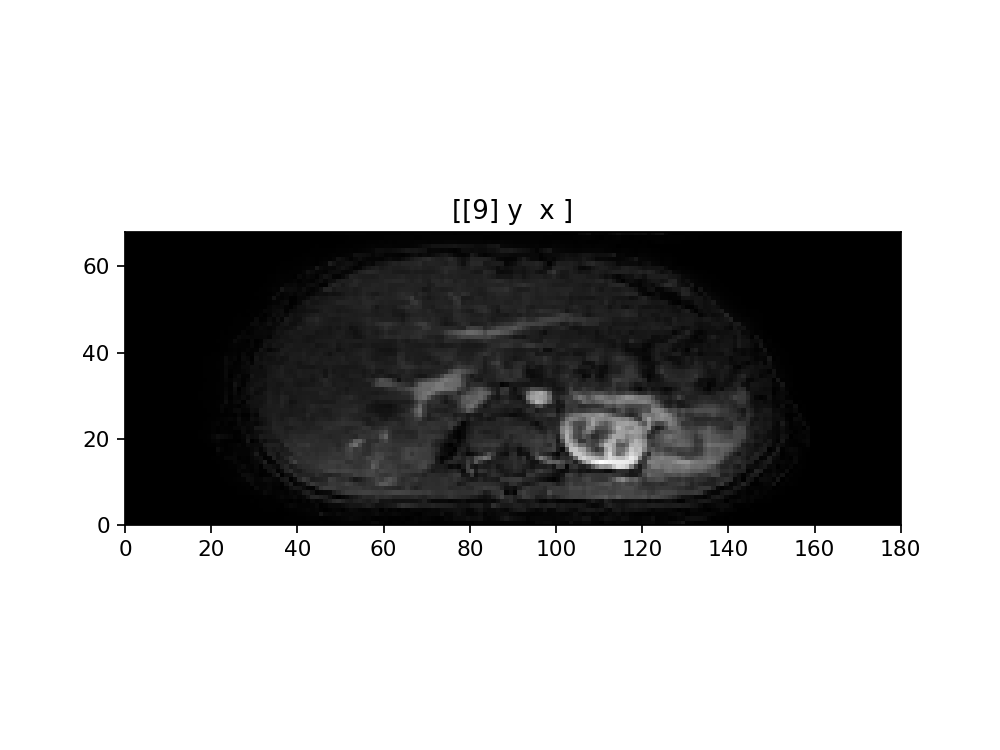

In [7]:
# Optional - view with Sigpy
recon_l1wav_CLI_transposed = np.moveaxis(recon_l1wav_CLI_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
recon_l1wav_CLI_rotated = np.rot90(recon_l1wav_CLI_transposed,2)

%matplotlib notebook
pl.ImagePlot(recon_l1wav_CLI_rotated)

#### option 2: using the python binding + cfl files 
You can use this option if you sapved the sens maps to memoery in the cfl format

In [8]:
recon_l1wav = bart(1, 'pics -d 5 -i 30 -p {} -R W:7:0:0.005 {} {}'.format("data/weights","data/ksp","data/maps"))  # explanation: 7 = $(bart bitmask 0 1 2)


#### option3: using the python binding + numpy arrays
Here we use the numpy arrays that we created earlier: ksp and sens_maps. We can also read them from memory 

In [11]:
# Remember that previously we ran these commands, which created the numpy arrays "ksp" and "sens_maps":
ksp = cfl.readcfl('data/ksp')

ksp_t_avg = bart(1,"avg -w $(bart bitmask 10) {}".format("data/ksp"))
sens_maps = bart(1, 'ecalib -t 0.02 -c 0.5 -m 2', ksp_t_avg[:,:,:,:])

recon_l1wav = bart(1, 'pics -d 5 -i 30 -p {} -R W:7:0:0.005'.format("data/weights"), ksp , sens_maps)  # explanation: 7 = $(bart bitmask 0 1 2)



#### Display

<IPython.core.display.Javascript object>


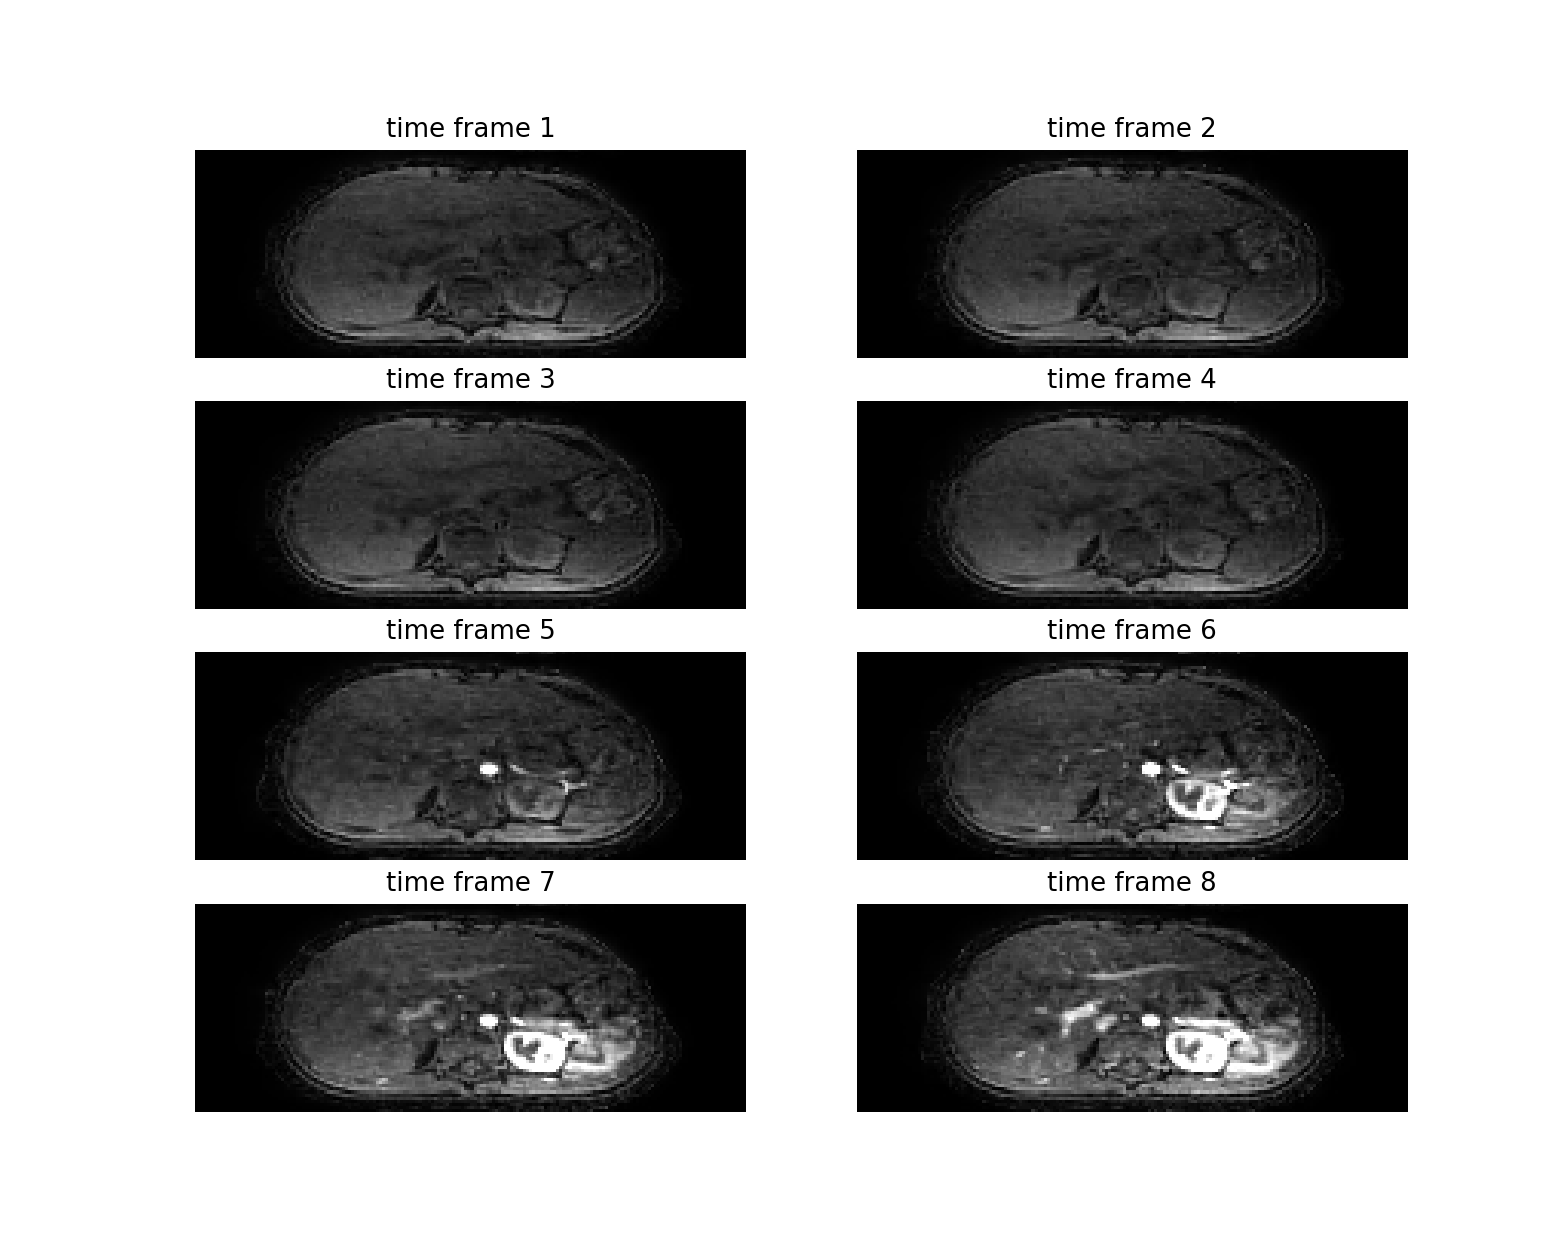

In [12]:
recon_l1wav_sqz = recon_l1wav[0,:,:,0,0,0,0,0,0,0,:].squeeze()

# display - let's view the first 8 time frames (of 20)
fig = plt.figure(figsize = (10,8))
for t_ind in range(8):
    im_frame = recon_l1wav_sqz[:,:,t_ind].squeeze()
    plt.subplot(4,2,t_ind+1)
    plt.imshow(np.abs(im_frame),cmap="gray")
    plt.clim(0,5)
    plt.axis('off')
    plt.title('time frame {}'.format(t_ind+1))
plt.show()

<IPython.core.display.Javascript object>


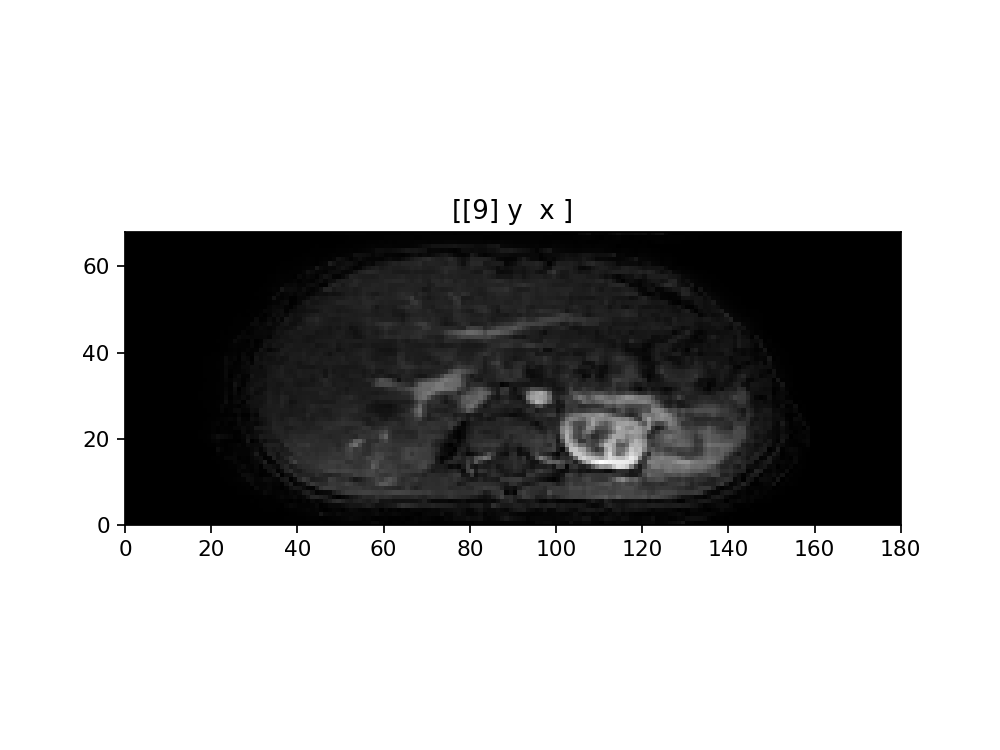

In [13]:
# Optional - view with Sigpy

recon_l1wav_transposed = np.moveaxis(recon_l1wav_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
recon_l1wav_rotated = np.rot90(recon_l1wav_transposed,2)

%matplotlib notebook
pl.ImagePlot(recon_l1wav_rotated)

## Regularization Example 2: Total Variation (TV) in Time


In [14]:
! bart pics -d 5 -i 100 -p data/weights -R T:$(bart bitmask 10):0:.04 data/ksp data/maps data/recon_tv


2 maps.
ESPIRiT reconstruction.
Size: 220320 Samples: 17236 Acc: 12.78
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 1x5x2, pos: 0x31x89)
Scaling: 329041.093750! (max = 329041.093750/p90 = 329041.093750/median = 153375.046875)
Inverse scaling of the data: 329041.093750
TV regularization: 0.040000
ADMM
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 2-3 of 5.
Linking args 2-3 of 5.
#0: 413.914062
#1: 264.020050
#2: 97.434799
#3: 54.972595
#4: 29.899677
#5: 19.002523
#6: 15.058923
#7: 13.154887
#8: 10.595448
#9: 7.544009
	 cg:  10
iter	cgiter	       rho	       tau	    r norm	   eps pri	    s norm	  eps dual	       obj	    relMSE
  0	 10	    0.5000	    2.0000	   45.0257	    0.0000	   55.5044	    0.0000	   -1.0000	   -1.0000
#0: 55.021084
#1: 22.556528
#2: 11.240451
#3: 6.535937
#4: 5.045862
#5: 3.769630
#6: 3.358045
#7: 2.969501
#8: 2.337090
#9: 1.906006
	 c

<IPython.core.display.Javascript object>


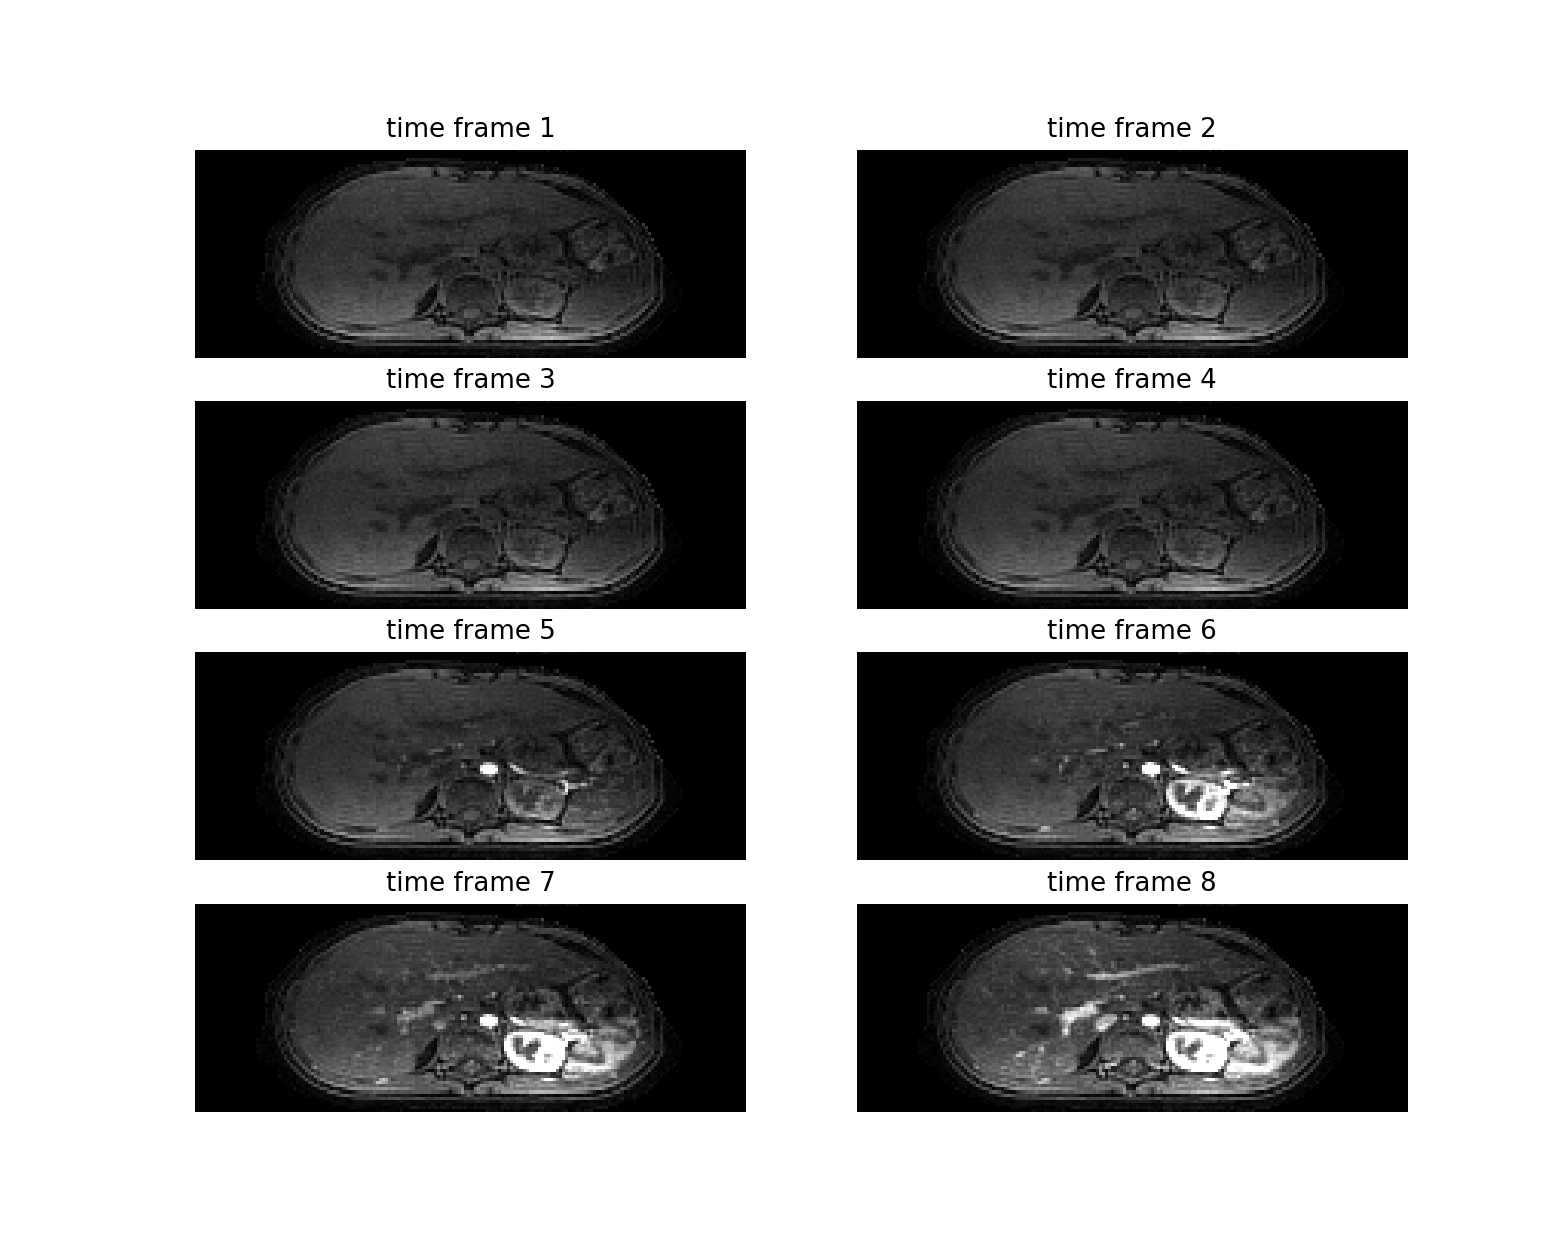

In [15]:
# load
recon_tv = cfl.readcfl('data/recon_tv')
recon_tv_sqz = recon_tv[0,:,:,0,0,0,0,0,0,0,:].squeeze()

# display - let's view the first 8 time frames (of 20)
fig = plt.figure(figsize = (10,8))
for t_ind in range(8):
    im_frame = recon_tv_sqz[:,:,t_ind].squeeze()
    plt.subplot(4,2,t_ind+1)
    plt.imshow(np.abs(im_frame),cmap="gray")
    plt.clim(0,5)
    plt.axis('off')
    plt.title('time frame {}'.format(t_ind+1))
plt.show()

## Regularization Example 3: Two regularizers - *l*1-wavelet in Space and Total Variation (TV) in Time


#### option 1: using BART's CLI

In [16]:
! bart pics -d 5 -i 100 -p data/weights -R W:$(bart bitmask 0 1 2):0:0.001 -R T:$(bart bitmask 10):0:.04 data/ksp data/maps data/recon_wavtv


2 maps.
ESPIRiT reconstruction.
Size: 220320 Samples: 17236 Acc: 12.78
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 1x5x2, pos: 0x31x89)
Scaling: 329041.093750! (max = 329041.093750/p90 = 329041.093750/median = 153375.046875)
Inverse scaling of the data: 329041.093750
l1-wavelet regularization: 0.001000
TV regularization: 0.040000
ADMM
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 2-3 of 5.
Linking args 2-3 of 5.
#0: 413.914062
#1: 163.934036
#2: 43.806950
#3: 16.241859
#4: 5.960238
#5: 2.369420
#6: 1.112463
#7: 0.505346
	 cg:   7
iter	cgiter	       rho	       tau	    r norm	   eps pri	    s norm	  eps dual	       obj	    relMSE
  0	  8	    0.5000	    2.0000	  215.1857	    0.0000	  297.6293	    0.0000	   -1.0000	   -1.0000
#0: 294.102234
#1: 100.595604
#2: 31.104757
#3: 11.947711
#4: 4.854866
#5: 2.147443
#6: 1.010030
	 cg:   6
  1	 15	    0.5000	    2

<IPython.core.display.Javascript object>


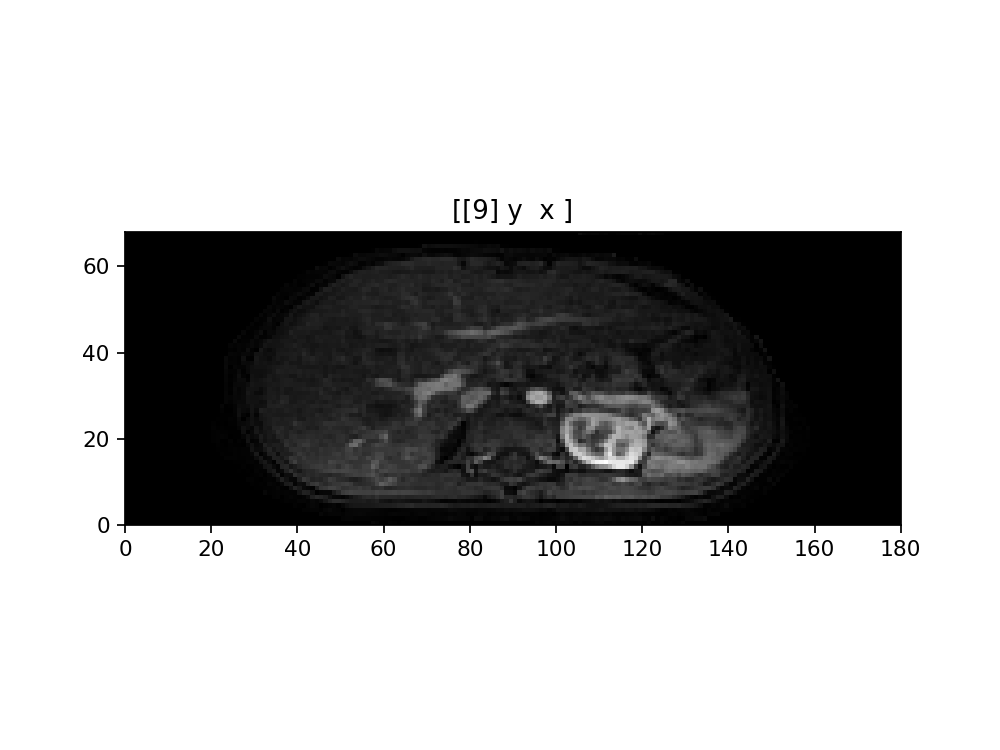

In [17]:
recon_wavTV = cfl.readcfl('data/recon_wavtv')

# view the recon
recon_wavTV_sqz = recon_wavTV[0,:,:,0,0,0,0,0,0,0,:].squeeze()
recon_wavTV_transpose = np.moveaxis(recon_wavTV_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
recon_wavTV_rotated = np.rot90(recon_wavTV_transpose,2)

pl.ImagePlot(recon_wavTV_rotated)

#### option 2: using bart's python binding

In [18]:
sens_maps = cfl.readcfl('data/maps') 
print(sens_maps.dtype)
print(sens_maps.shape)

ksp = cfl.readcfl('data/ksp') 
print(ksp.dtype)
print(ksp.shape)

recon_wavTV = bart(1, 'pics -i 100 -p {} -R W:7:0:0.001 -R T:1024:0:.04 '.format("data/weights"),ksp , sens_maps)  


complex64
(1, 68, 180, 20, 2)
complex64
(1, 68, 180, 20, 1, 1, 1, 1, 1, 1, 18)


#### Display

<IPython.core.display.Javascript object>


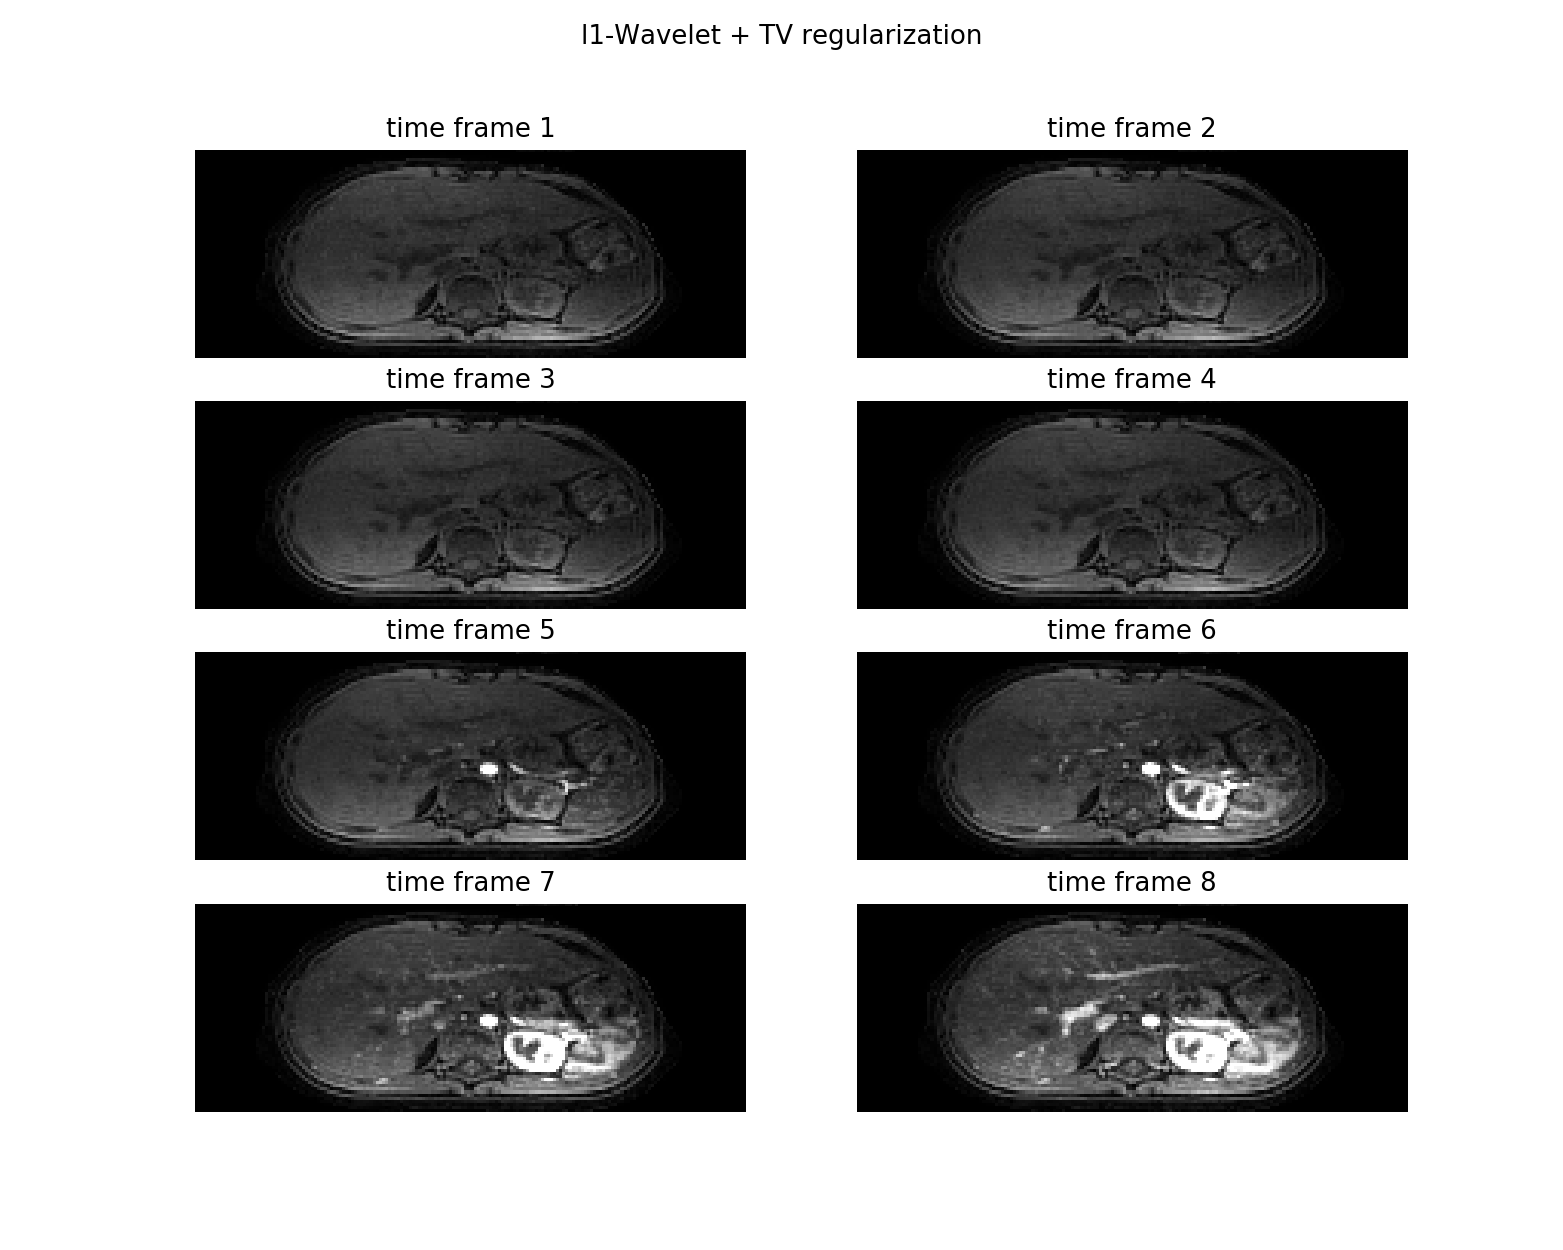

In [19]:
recon_wavTV_sqz = recon_wavTV[0,:,:,0,0,0,0,0,0,0,:].squeeze()

# display - let's view the first 8 time frames (of 20)
fig = plt.figure(figsize = (10,8))
for t_ind in range(8):
    im_frame = recon_wavTV_sqz[:,:,t_ind].squeeze()
    plt.subplot(4,2,t_ind+1)
    plt.imshow(np.abs(im_frame),cmap="gray")
    plt.clim(0,5)
    plt.axis('off')
    plt.title('time frame {}'.format(t_ind+1))

plt.suptitle('l1-Wavelet + TV regularization')
plt.show()

<IPython.core.display.Javascript object>


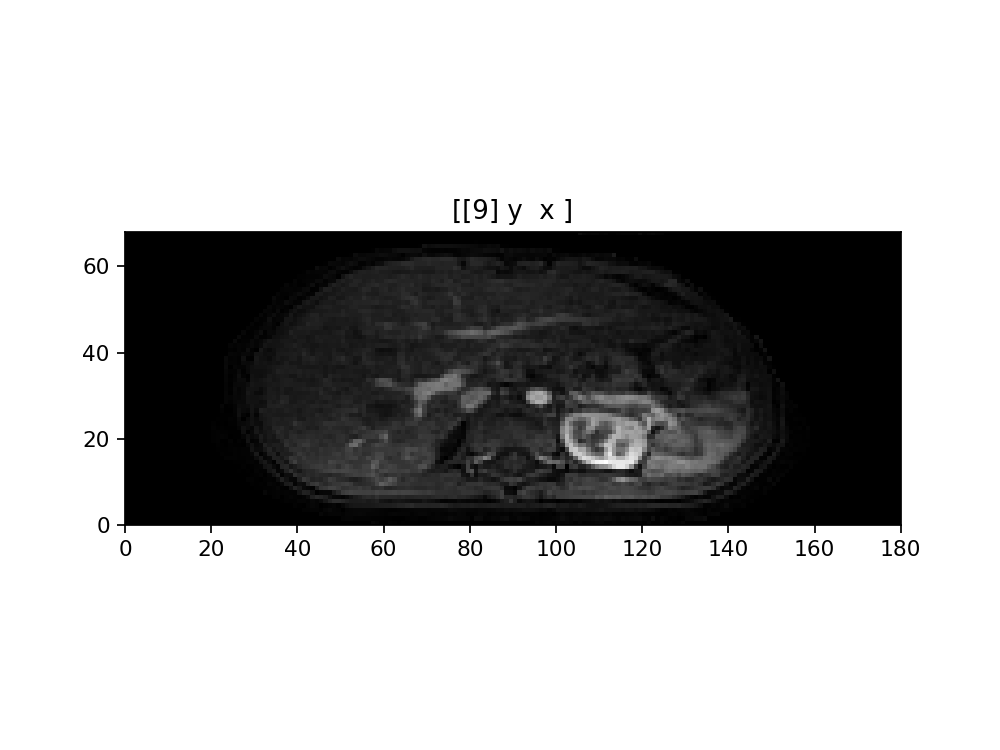

In [20]:
# view the recon with Sigpy
recon_wavTV_sqz = recon_wavTV[0,:,:,0,0,0,0,0,0,0,:].squeeze()
recon_wavTV_transpose = np.moveaxis(recon_wavTV_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
recon_wavTV_rotated = np.rot90(recon_wavTV_transpose,2)

pl.ImagePlot(recon_wavTV_rotated)

## Compare the reconstructions of the different regularizers

<IPython.core.display.Javascript object>


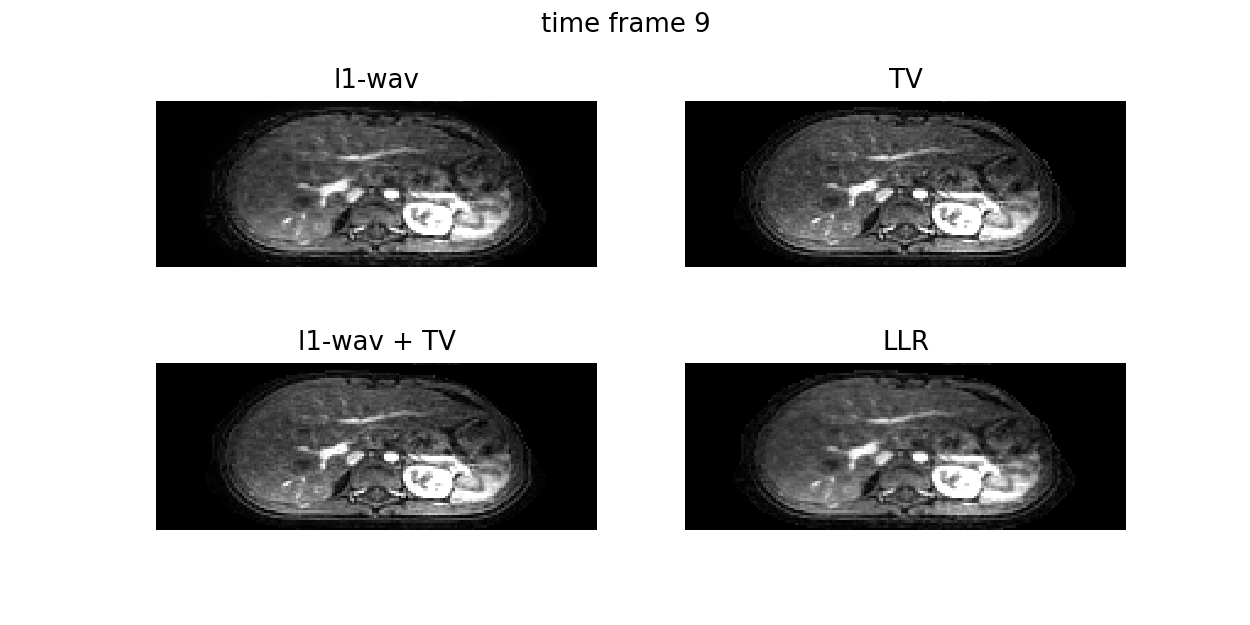

In [21]:
recon_l1wav = cfl.readcfl('data/recon_l1wav')
recon_tv = cfl.readcfl('data/recon_tv')
recon_wavTV = cfl.readcfl('data/recon_wavtv')
recon_LLR = cfl.readcfl('data/recon_LLR')  # Notice: this reconstruction was created in the first jupyter notebook


t_ind = 8  # choose a time frame

recon_l1wav_t = recon_l1wav[0,:,:,0,0,0,0,0,0,0,t_ind].squeeze()
recon_tv_t = recon_tv[0,:,:,0,0,0,0,0,0,0,t_ind].squeeze()
recon_wavTV_t = recon_wavTV[0,:,:,0,0,0,0,0,0,0,t_ind].squeeze()
recon_LLR_t = recon_LLR[0,:,:,0,0,0,0,0,0,0,t_ind].squeeze()

recs_array = np.concatenate((recon_l1wav_t,recon_l1wav_t,recon_wavTV_t,recon_LLR_t),axis=0)

fig = plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plt.imshow(np.abs(recon_l1wav_t),cmap="gray")
plt.clim(0,5)
plt.axis('off')
plt.title('l1-wav')

plt.subplot(2,2,2)
plt.imshow(np.abs(recon_tv_t),cmap="gray")
plt.clim(0,5)
plt.axis('off')
plt.title('TV')

plt.subplot(2,2,3)
plt.imshow(np.abs(recon_wavTV_t),cmap="gray")
plt.clim(0,5)
plt.axis('off')
plt.title('l1-wav + TV')

plt.subplot(2,2,4)
plt.imshow(np.abs(recon_LLR_t),cmap="gray")
plt.clim(0,5)
plt.axis('off')
plt.title('LLR')

plt.suptitle('time frame {}'.format(t_ind+1))
plt.show()


We hope you enjoyed this additional tutorial!

Efrat & Jon